In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# 변환기 파이프라인
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 로딩 및 변환
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 미니배치 처리를 위한 데이터로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([4, 3, 32, 32])
torch.Size([4, 32, 32, 3])


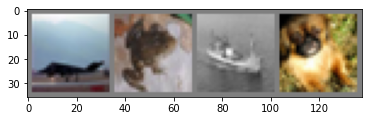

plane        frog        ship         dog


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # transpose 이유 (pytorch (channel, wieght, height))이기에
    # (wieght, height, channel) 순으로 변경 필요
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print((np.transpose(images, (0, 2, 3, 1))).shape)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print('       '.join('%5s' % classes[labels[j]] for j in range(4)))

# CNN 정의하기

In [4]:
import torch.nn as nn
import torch.nn.functional as F

## torch.nn.functional에는
- Convolution functions
- Pooling functions
- Non-linear activation functions
- Normalization functions
- Linear functions 
- Dropout functions
- Sparse functions (embedding, one_hot)
- Distance functions (cosine_similarity, 
- Loss functions (binary_cross_entropy...)
- Vision functions (pixel_shuffle, interpolate, upsample
- DataParallel functions (multi-GPU, distributed) (data_parallel)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # (input, output, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = Net()

In [6]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # (input, output, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.conv4 = nn.Conv2d(32, 128, 5)
        self.fc1 = nn.Linear(128*5*5, 580)
        self.fc2 = nn.Linear(580, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

net2 = Net2()

## 손실함수와 Optimizer 정의

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 신경망 학습

In [8]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후:
        inputs, labels = data
        
        # Gradient 매개변수를 0으로 만들고
        optimizer.zero_grad()
        
        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 통계 출력
        running_loss += loss.item()
        if i % 2000 == 1999:   # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f'%(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.237
[1,  4000] loss: 1.872
[1,  6000] loss: 1.696
[1,  8000] loss: 1.565
[1, 10000] loss: 1.518
[1, 12000] loss: 1.472
[2,  2000] loss: 1.414
[2,  4000] loss: 1.391
[2,  6000] loss: 1.336
[2,  8000] loss: 1.343
[2, 10000] loss: 1.316
[2, 12000] loss: 1.295
Finished Training


In [9]:
torch.cuda.is_available()

True

## 모델 저장
- Recommended approach for saving a model
- There are two main approaches for serializing and restoring a model.

- The first (recommended) saves and loads only the model parameters:
```
torch.save(the_model.state_dict(), PATH)
```
- Then later:
```
the_model = TheModelClass(*args, **kwargs)
the_model.load_state_dict(torch.load(PATH))
```
- The second saves and loads the entire model:
```
torch.save(the_model, PATH)
```
- Then later:
```
the_model = torch.load(PATH)
```

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test 데이터로 예측

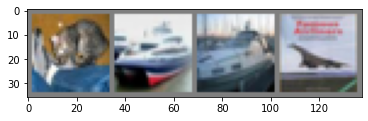

GT:    cat        ship        ship       plane


In [11]:
dataiter = iter(testloader)   # iter : 무작위 추출
images, labels = dataiter.next()

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GT: ', '       '.join('%5s'%classes[labels[j]] for j in range(4)))

## 모델 로드

In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 예측

In [13]:
output = net(images)

In [14]:
_, predicted = torch.max(outputs, 1)
'''
for idx, data in enumerate(testloader):
    images, labels = data
    imshow(torchvision.utils.make_grid(images))
print(images)
#images, labels = dataiter
'''
print('Predicted: ', ' '.join('%5s'%classes[predicted[j]] for j in range(4)))

Predicted:  plane   dog horse  ship


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        

Accuracy of the network on the 10000 test images: 53 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 62 %
Accuracy of  bird : 33 %
Accuracy of   cat : 42 %
Accuracy of  deer : 27 %
Accuracy of   dog : 45 %
Accuracy of  frog : 62 %
Accuracy of horse : 71 %
Accuracy of  ship : 82 %
Accuracy of truck : 47 %


## GPU에서 학습

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
net2.to(device)

Net2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=580, bias=True)
  (fc2): Linear(in_features=580, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후:
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # Gradient 매개변수를 0으로 만들고
        optimizer.zero_grad()
        
        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 통계 출력
        running_loss += loss.item()
        if i % 2000 == 1999:   # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f'%(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small